In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

In [2]:
# Load data from an Excel file 
path = '../data/excel/LAEI2013_MajorRoads_EmissionsbyLink_2013.xlsx'
df = pd.read_excel(path)

## Data Cleaning

In [3]:
df.columns

Index(['GridId', 'Toid', 'GRID_ExactCut_ID', 'Location_ExactCut',
       'BoroughName_ExactCut', 'Lts', 'Length (m)', 'Emissions', 'Year',
       'Pollutant', 'Emissions Unit', 'Motorcycle', 'Taxi', 'Car',
       'BusAndCoach', 'Lgv', 'Rigid', 'Artic', 'Rigid2Axle', 'Rigid3Axle',
       'Rigid4Axle', 'Artic3Axle', 'Artic5Axle', 'Artic6Axle', 'PetrolCar',
       'DieselCar', 'PetrolLgv', 'DieselLgv', 'LtBus', 'Coach', 'ElectricCar',
       'ElectricLgv'],
      dtype='object')

In [4]:
df_proc = df.replace(0, np.nan)

In [5]:
df_proc.isnull().sum()

GridId                       0
Toid                         0
GRID_ExactCut_ID             0
Location_ExactCut            0
BoroughName_ExactCut         0
Lts                          0
Length (m)                3760
Emissions                    0
Year                         0
Pollutant                    0
Emissions Unit               0
Motorcycle               98236
Taxi                     31800
Car                      13740
BusAndCoach             107950
Lgv                      17240
Rigid                    25940
Artic                    63140
Rigid2Axle               25940
Rigid3Axle               72900
Rigid4Axle               57020
Artic3Axle               78870
Artic5Axle               63150
Artic6Axle               90120
PetrolCar                13740
DieselCar                13740
PetrolLgv                17240
DieselLgv                17240
LtBus                   142250
Coach                   233520
ElectricCar             154732
ElectricLgv             156832
dtype: i

In [6]:
df_proc.dtypes

GridId                    int64
Toid                      int64
GRID_ExactCut_ID          int64
Location_ExactCut        object
BoroughName_ExactCut     object
Lts                       int64
Length (m)              float64
Emissions                object
Year                      int64
Pollutant                object
Emissions Unit           object
Motorcycle              float64
Taxi                    float64
Car                     float64
BusAndCoach             float64
Lgv                     float64
Rigid                   float64
Artic                   float64
Rigid2Axle              float64
Rigid3Axle              float64
Rigid4Axle              float64
Artic3Axle              float64
Artic5Axle              float64
Artic6Axle              float64
PetrolCar               float64
DieselCar               float64
PetrolLgv               float64
DieselLgv               float64
LtBus                   float64
Coach                   float64
ElectricCar             float64
Electric

In [7]:
df_proc.drop(['ElectricLgv', 
              'ElectricCar', 
              'Coach', 
              'LtBus', 
              'BusAndCoach', 
              'Motorcycle', 
              'GridId', 
              'Toid', 
              'GRID_ExactCut_ID', 
              'Location_ExactCut', 
              'BoroughName_ExactCut', 
              'Emissions Unit', 
              'Year', 
              'Emissions', 
              'Lts'], 
             axis=1, inplace=True)

In [8]:
df_proc = df_proc.dropna()

In [9]:
df_proc.describe

<bound method NDFrame.describe of         Length (m)  Pollutant          Taxi        Car        Lgv     Rigid  \
0        50.761449        CO2  3.748545e-01  13.572217   1.772671  1.538737   
2         5.101391        CO2  3.954047e-02   1.457712   0.188471  0.169197   
3         3.757501        CO2  2.912409e-02   1.073698   0.138821  0.124625   
4         1.624593        CO2  1.259209e-02   0.464224   0.060020  0.053883   
5       294.077765        CO2  2.279373e+00  84.032104  10.864684  9.753649   
...            ...        ...           ...        ...        ...       ...   
366212  178.704000  PM25_Tyre  4.281042e-06   0.004383   0.000865  0.000265   
366213   36.867781  PM25_Tyre  8.832063e-07   0.000904   0.000178  0.000055   
366217  150.698967  PM25_Tyre  4.013647e-05   0.001810   0.000318  0.000201   
366218   27.459057  PM25_Tyre  7.313319e-06   0.000330   0.000058  0.000037   
366219   27.432124  PM25_Tyre  7.306146e-06   0.000329   0.000058  0.000037   

           Artic 

In [10]:
df_proc.head(1)

,Length (m),Pollutant,Taxi,Car,Lgv,Rigid,Artic,Rigid2Axle,Rigid3Axle,Rigid4Axle,Artic3Axle,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv
0,50.761449,CO2,0.374854,13.572217,1.772671,1.538737,0.609006,1.045237,0.178038,0.315462,0.177074,0.241372,0.19056,8.761443,4.810774,0.03755,1.735121


In [11]:
df_proc.columns[1]

'Pollutant'

## Preprocessing Data

#### Encoding Data

In [12]:
# Encoding Pollutants
encoder = LabelEncoder()
df_proc['Pollutant'] = encoder.fit_transform(df_proc['Pollutant'])
df_proc['Pollutant'].unique()
df_encoded = df_proc.copy()

#### Scaling Data

In [13]:
scaler = StandardScaler()

# Apply StandardScaler to each column except the Pollutant column with categorical data
for col in df_encoded.columns:
    if df_encoded.columns.get_loc(col) != 1:  # Checks if the column index is not 1
        df_encoded[col] = scaler.fit_transform(df_encoded[[col]])   

In [14]:
scaled_df = df_encoded.copy()

In [15]:
scaled_df.columns

Index(['Length (m)', 'Pollutant', 'Taxi', 'Car', 'Lgv', 'Rigid', 'Artic',
       'Rigid2Axle', 'Rigid3Axle', 'Rigid4Axle', 'Artic3Axle', 'Artic5Axle',
       'Artic6Axle', 'PetrolCar', 'DieselCar', 'PetrolLgv', 'DieselLgv'],
      dtype='object')

In [16]:
scaled_df.head(10)

,Length (m),Pollutant,Taxi,Car,Lgv,Rigid,Artic,Rigid2Axle,Rigid3Axle,Rigid4Axle,Artic3Axle,Artic5Axle,Artic6Axle,PetrolCar,DieselCar,PetrolLgv,DieselLgv
0,-0.146272,0,0.133231,0.574161,0.533644,0.335339,0.307420,0.347038,0.298492,0.312592,0.309436,0.262045,0.377198,0.564902,0.590562,0.520822,0.533923
2,-0.716215,0,-0.070241,-0.095218,-0.099697,-0.102513,-0.102275,-0.101933,-0.104553,-0.100574,-0.102088,-0.107975,-0.092938,-0.095448,-0.094599,-0.099587,-0.099699
3,-0.732990,0,-0.076562,-0.116436,-0.119547,-0.116763,-0.116013,-0.116425,-0.118014,-0.114190,-0.115880,-0.120391,-0.108696,-0.116330,-0.116411,-0.119376,-0.119550
4,-0.759613,0,-0.086594,-0.150112,-0.151050,-0.139380,-0.137816,-0.139426,-0.139378,-0.135799,-0.137770,-0.140096,-0.133705,-0.149474,-0.151030,-0.150783,-0.151055
5,2.890879,0,1.288916,4.467370,4.168503,2.961707,2.851740,3.014282,2.789966,2.827114,2.863663,2.561803,3.295455,4.394956,4.595697,4.155635,4.168761
7,1.711668,0,1.423972,4.900743,4.646585,3.405233,3.294391,3.554147,2.690106,3.279174,3.003356,3.516175,3.234697,4.852863,4.981841,4.703752,4.645295
8,1.921565,0,3.204917,10.811427,10.140913,13.041500,13.458369,12.933044,13.408688,12.838820,13.797091,13.333641,13.251427,10.669753,11.058498,10.232518,10.138831
9,0.604492,0,0.402751,1.462729,1.373354,0.918235,0.854650,0.944197,0.836596,0.863383,0.859078,0.756318,1.005128,1.441263,1.500503,1.344938,1.373973
10,-0.214361,0,0.118858,0.539574,0.494136,0.323811,0.308716,0.331625,0.298160,0.306754,0.310536,0.263470,0.378488,0.529300,0.557960,0.492440,0.494170
11,-0.757319,0,-0.085729,-0.147210,-0.148335,-0.137431,-0.135937,-0.137444,-0.137537,-0.133936,-0.135884,-0.138398,-0.131550,-0.146618,-0.148046,-0.148077,-0.148340


## Exploring Data

##### Uncomment the code below to visualize the distribution of each feature using histograms.

In [17]:
'''# Visualize the distribution of each feature using histograms.
plt.figure(figsize=(18, 9))
column_names = scaled_df.columns
column_names = column_names.to_list()
for i, feature in enumerate(column_names):
    plt.subplot(4, 4, i + 1)
    sns.histplot(data=scaled_df, x=feature, kde=True)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()'''

"# Visualize the distribution of each feature using histograms.\nplt.figure(figsize=(18, 9))\ncolumn_names = scaled_df.columns\ncolumn_names = column_names.to_list()\nfor i, feature in enumerate(column_names):\n    plt.subplot(4, 4, i + 1)\n    sns.histplot(data=scaled_df, x=feature, kde=True)\n    plt.title(f'{feature} Distribution')\nplt.tight_layout()\nplt.show()"

## PCA model for dimensionality Reduction and Data Exploration

#### Step 1: Determine the optimal number of components

In [18]:
# calculate covariance matrix, eigenvalues and eigenvectors
cov_mat = np.cov(scaled_df.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

exp_var = []

# Sort the eigenvalues in descending order
eigen_vals = np.sort(eigen_vals)[::-1]

for i in eigen_vals:
  var = (i / np.sum(eigen_vals)) * 100
  exp_var.append(var)

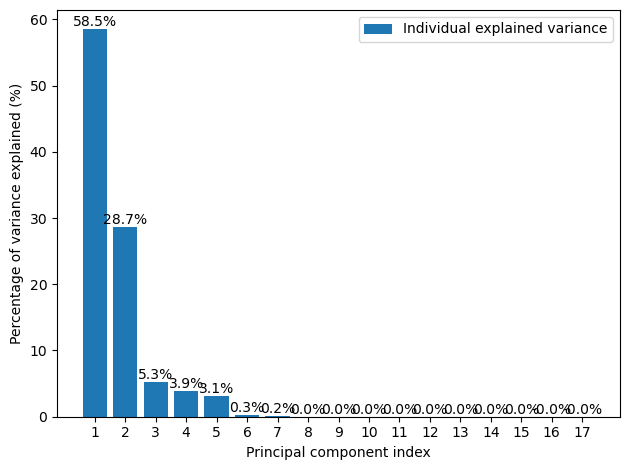

In [19]:
# Visualize the explained variance of each principal component as a bar plot
bar = plt.bar(range(1, 18), exp_var, align='center',
        label='Individual explained variance')

# Adding data labels to the top of bars 
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{exp_var[i]:.1f}%', 
             ha='center', va='bottom')

plt.ylabel('Percentage of variance explained (%)')
plt.xlabel('Principal component index')
plt.xticks(ticks=list(range(1, 18)))
plt.legend(loc='best')
plt.tight_layout()

Text(0.5, 1.0, 'Scree Plot')

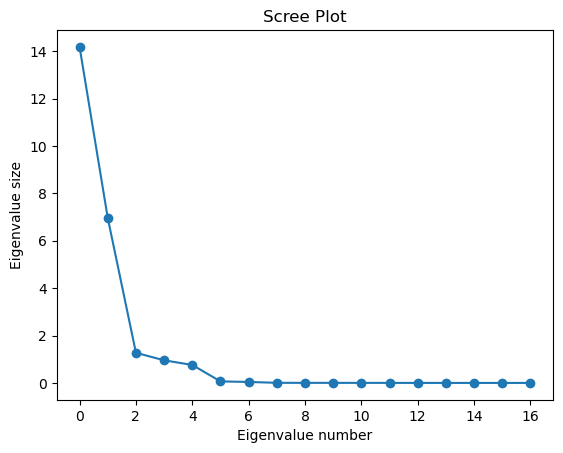

In [20]:
# Perform Principal Component Analysis (PCA) on the scaled dataset
# The Scree Plot visualizes the eigenvalues (explained variance) of each principal component
pca = PCA()
x = pca.fit_transform(scaled_df)
explained_variance = pca.explained_variance_ratio_
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

#### Step 2: Apply PCA

#### PCA with 3 prinicpal components: creating the model and evaluating the results

In [21]:
# Create PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_df)
print(f'Sum of PCA explained variance ratio: {sum(pca.explained_variance_ratio_)} \n===============================')
print(f'PCA explained variance ratio: {pca.explained_variance_ratio_} \n===============================')

# Generate loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=scaled_df.columns)
print(f'Loadings:\n{loadings_df}\n===============================')

# Create DataFrame with principal components
pca_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2', 'PC3'])
print(pca_df)

Sum of PCA explained variance ratio: 0.9245122453246769 
PCA explained variance ratio: [0.58488676 0.2871222  0.05250329] 
Loadings:
                 PC1       PC2       PC3
Length (m)  0.172932  0.124092 -0.199506
Pollutant  -1.596530  2.387288 -0.034354
Taxi        0.461204  0.126473 -0.242712
Car         0.896620  0.263452 -0.314105
Lgv         0.891003  0.260678 -0.345855
Rigid       0.913529  0.320350  0.247628
Artic       0.909295  0.321658  0.261903
Rigid2Axle  0.912456  0.318992  0.243027
Rigid3Axle  0.911105  0.320368  0.246263
Rigid4Axle  0.895652  0.316580  0.256360
Artic3Axle  0.907532  0.320478  0.262616
Artic5Axle  0.910552  0.321145  0.257054
Artic6Axle  0.905896  0.322588  0.268015
PetrolCar   0.894961  0.264098 -0.319513
DieselCar   0.898028  0.261725 -0.303273
PetrolLgv   0.890685  0.260840 -0.345158
DieselLgv   0.891004  0.260673 -0.345869
              PC1       PC2       PC3
0        3.319593 -3.432878 -0.253683
1        1.530990 -4.265177  0.264996
2        1.4732

#### PCA with 3 prinicpal components: visualise results

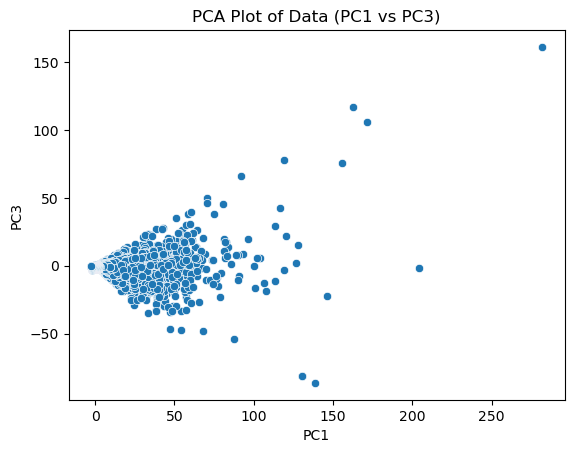

In [22]:
# Visualize the data using a scatter plot of the first principal components (PC1 vs PC2)
ax = sns.scatterplot(x=pca_df.iloc[:, 0], y=pca_df.iloc[:, 2])
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PCA Plot of Data (PC1 vs PC3)')
plt.show()

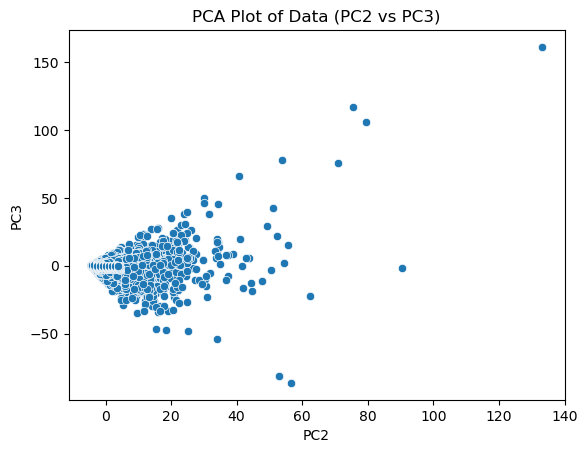

In [23]:
# Visualize the data using a scatter plot of the first principal components (PC2 vs PC3)
ax = sns.scatterplot(x=pca_df.iloc[:, 1], y=pca_df.iloc[:, 2])
plt.xlabel('PC2')
plt.ylabel('PC3')
plt.title('PCA Plot of Data (PC2 vs PC3)')
plt.show()

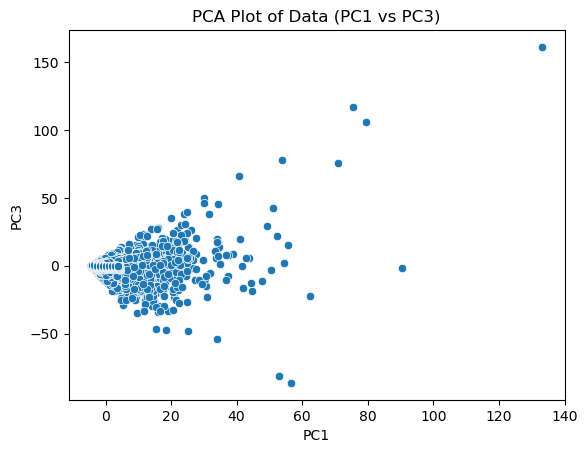

In [24]:
# Visualize the data using a scatter plot of the two principal components (PC1 vs PC3)
ax = sns.scatterplot(x=pca_df.iloc[:, 1], y=pca_df.iloc[:, 2])
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.title('PCA Plot of Data (PC1 vs PC3)')
plt.show()

#### PCA with 2 prinicpal components: creating the model and evaluating the results

###### Since PC2 vs PC3 and PC1 vs PC3 look similar, it could indicate that PC3 might capture less variance in the data compared to PC1 and PC2, so we try again with 2 components

In [25]:
# Create PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_df)
print(f'Sum of PCA explained variance ratio: {sum(pca.explained_variance_ratio_)} \n===============================')
print(f'PCA explained variance ratio: {pca.explained_variance_ratio_} \n===============================')

# Find most relevant features for PC1 and PC2
print(f'Most relevant features: {abs(pca.components_)}\n===============================')

# Generate loadings
pca_df = pd.DataFrame(data = principalComponents, columns=['PC1', 'PC2'])
pca_df.reset_index(drop=True, inplace=True)
print(pca_df)

Sum of PCA explained variance ratio: 0.8720089564661944 
PCA explained variance ratio: [0.58488676 0.2871222 ] 
Most relevant features: [[0.04591803 0.42392073 0.12246172 0.23807608 0.23658464 0.24256585
  0.24144168 0.24228089 0.24192226 0.23781916 0.24097363 0.24177553
  0.24053903 0.23763571 0.23845005 0.23650023 0.23658506]
 [0.04702775 0.9047211  0.0479301  0.09984177 0.09879022 0.12140461
  0.12190024 0.12088996 0.12141133 0.11997585 0.12145296 0.12170587
  0.12225247 0.10008629 0.09918698 0.0988516  0.09878827]]
              PC1       PC2
0        3.319593 -3.432878
1        1.530990 -4.265177
2        1.473263 -4.292056
3        1.381644 -4.334716
4       13.943996  1.514618
...           ...       ...
274355  -2.400427  3.880436
274356  -2.482178  3.796975
274357  -2.416769  3.863871
274358  -2.487637  3.791423
274359  -2.487653  3.791407

[274360 rows x 2 columns]


#### PCA with 2 prinicpal components: visualise results

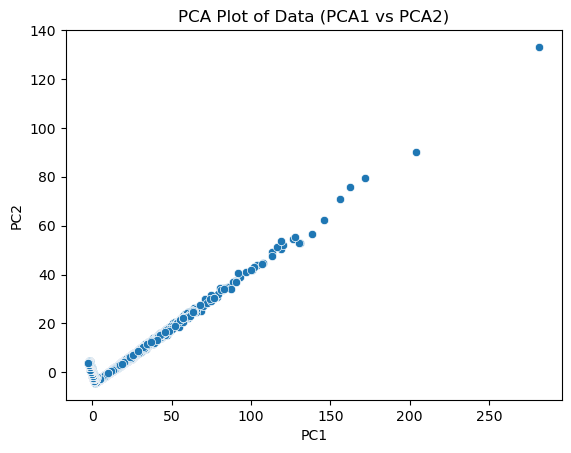

In [26]:
# Visualize the data using a scatter plot of the two principal components (PC1 vs PC2)
ax = sns.scatterplot(x=pca_df.iloc[:, 0], y=pca_df.iloc[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot of Data (PCA1 vs PCA2)')
plt.show()